In [1]:
# default_exp plotting.main

In [2]:
# export
import matplotlib.pyplot as plt
#from pathos.multiprocessing import ProcessingPool as Pool

In [3]:
# export 
import matplotlib.pyplot as plt
from montlake.plotting.manifolds import plot_manifold_2d, plot_manifold_3d,plot_manifold_featurespace
from montlake.plotting.plotting import plot_cosines, get_cmap,get_names, plot_cosines_cluster
from montlake.plotting.flasso import plot_reg_path_ax_lambdasearch_customcolors_norm,plot_watch_custom, plot_watch,plot_cos_boxes
import dill as pickle
import pathos
from montlake.utils.utils import data_stream_custom_range, cosine_similarity
from pathos.multiprocessing import ProcessingPool as Pool
from montlake.atomgeom.features import get_features
from montlake.utils.utils import get_atoms4_full, get_index_matching, get_cosines
from montlake.utils.replicates import get_detected_values2d
import numpy as np
import itertools
import seaborn as sns
from matplotlib.patches import Rectangle

def plot_experiment(result_file, 
                    positions,
                    d,
                    name, 
                    outdir,
                    embedding= True, 
                    ground_truth = None, 
                    colors_id_all = None, 
                    color_counts_all = None,
                    name_counts_all = None, 
                    colors_gt = None,
                    names_gt = None,
                    cosine_cluster = False,
                   cosine_color = False,
                    gt_reg_color = False,
                    sel_reg_color = False,
                   n_components = 2,
                   alpha = 1,
                   ptsize = 1,
                    ncord = 6,
                   selected_cosines = False,
                   plot_watch_full = False,
                   plot_watch_results = False):
    
   
    
    print('loading data')
    with open(result_file,'rb') as inp:
        results = pickle.load(inp, pickle.HIGHEST_PROTOCOL)
        
    atoms4 = results['dictionary']['atoms4']
        
    p = results['replicates_small'][0].dg_M.shape[2]
    nreps = results['supports_lasso'][1].shape[0]
    embed = results['embed']
    
    if ground_truth is not None:
        print('compute ground truth values for comparison' )
        cores = pathos.multiprocessing.cpu_count() - 1
        pool = Pool(cores) 
        n = positions.shape[0]
        gt_results = pool.map(lambda i: get_features(positions[i],
                                   atoms2 = ground_truth['atoms2'],
                                   atoms3 = ground_truth['atoms3'],
                                   atoms4 = ground_truth['atoms4']),
            data_stream_custom_range(list(range(n))))
        values_gt = np.vstack([np.hstack(gt_results[i]) for i in range(n)])

    print('getting ground truth names')
    if names_gt is None and ground_truth is not None:
        natoms = positions.shape[1]
        #atoms4 = np.asarray(list(itertools.combinations(range(natoms), 4))) 
        superset = results['dictionary']['atoms4']#get_atoms4_full(atoms4) #needs adjustment for diagram dictionaries
        j1 = get_index_matching(ground_truth['atoms4'][0], superset) #needs adjustment for non torsion ground truths
        j2 = get_index_matching(ground_truth['atoms4'][1], superset)
        gt_ind = [j1,j2]
        names_gt = get_names(np.asarray(gt_ind))

    if ground_truth is not None:
        print('plotting ground truth function values')
        for k in range(len(gt_ind)):
            title = names_gt[k] +' ' +  str(atoms4[gt_ind[k]] + 1)
            if n_components == 3:
                plot_manifold_3d(embed, ptsize, alpha, values_gt[:,k], title,title_color = colors_gt[k])#, title_color = colors[s])  
            if n_components == 2:
                plot_manifold_2d(embed, ptsize, alpha, values_gt[:,k], title,title_color = colors_gt[k])
            
    if ground_truth is None:
        gt_ind = []
        colors_gt = np.empty((0,4), int)
        
    if color_counts_all is not None:
        print('getting all colors')
        colors_all = np.empty((0,4), int)
        for c in range(len(color_counts_all)):
            colors_all = np.vstack([colors_all, np.repeat([colors_id_all[c]], color_counts_all[c], axis = 0)])
    
    print('getting colors and names of selected functions')
    selected_lasso = results['selected_lasso']
    colors_lasso = get_cmap(selected_lasso)
    names_lasso = get_names(selected_lasso)
    selected_ts = results['selected_ts']
    colors_ts = get_cmap(selected_ts)
    names_ts = get_names(selected_ts)
    colors_lasso_full = np.zeros((p,4))
    colors_lasso_full[selected_lasso] = colors_lasso
    colors_ts_full = np.zeros((p,4))
    colors_ts_full[selected_ts] = colors_ts

    print('plotting top coordinates in feature space')
    data = results['data']
    title = name + ' top PCA'
    plot_manifold_featurespace(data,title,ncord)    
    plt.savefig(outdir + '/features')
    plt.close()
    
    print('plotting sample regularization path')
    if gt_reg_color:
        fig, axes_all = plt.subplots(figsize=(15, 10))
        #colors = np.zeros((p,4))
        #colors[subset_l0_plusgt] = colors_l0_plusgt
        plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, results['replicates_small'][0].cs_reorder, results['replicates_small'][0].xaxis_reorder / results['replicates_small'][0].xaxis_reorder.max() , fig,colors_all)#axes_all[0].imshow(asdf)
        axes_all.set_title('Regularization path (single replicate)', fontsize = 40)
        axes_all.set_ylabel(r'$||\beta_j||$', fontsize = 40)
        axes_all.set_xticklabels([])
        plt.tight_layout()
        plt.savefig(outdir + '/reg_path_gt')
        plt.close()
        
    if sel_reg_color:
        fig, axes_all = plt.subplots(figsize=(15, 10))
        plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, results['replicates_small'][0].cs_reorder, results['replicates_small'][0].xaxis_reorder / results['replicates_small'][0].xaxis_reorder.max() , fig,colors_lasso_full)#axes_all[0].imshow(asdf)
        axes_all.set_title('Regularization path (single replicate)', fontsize = 40)
        axes_all.set_ylabel(r'$||\beta_j||$', fontsize = 40)
        axes_all.set_xticklabels([])
        plt.tight_layout()
        plt.savefig(outdir + '/reg_path_sel')
        plt.close()
        
    if embedding:
        supports_lasso_values = np.vstack([np.hstack(results['supports_lasso_values'][i]) for i in range(n)])
        supports_ts_values = np.vstack([np.hstack(results['supports_ts_values'][i]) for i in range(n)])
        print('plotting selected function values', colors_ts.shape, supports_ts_values.shape)
        #for s in range(len(results['selected_lasso'])):
        for s in range(supports_lasso_values.shape[1]):
            c = supports_lasso_values[:,s]
            title_color = colors_lasso[s]
            title = names_lasso[s] + ' ' + str(atoms4[selected_lasso[s]] + 1)
            
            if n_components == 3:
                plot_manifold_3d(embed, ptsize, alpha, c, title,title_color = title_color)#, title_color = colors[s])  
            if n_components == 2:
                plot_manifold_2d(embed, ptsize, alpha, c, title,title_color = title_color)#, colors[s])
            plt.savefig(outdir + '/selected_function_lasso_'+ str(s))
            plt.close()
        #for s in range(len(results['selected_ts'])):
        for s in range(supports_ts_values.shape[1]):
            title_color = colors_ts[s]
            title = names_ts[s] + ' ' + str(atoms4[selected_ts[s]] + 1)
            c = supports_ts_values[:,s]
            if n_components == 3:
                plot_manifold_3d(embed, ptsize, alpha, c, title,title_color = title_color)#, colors_ts[s])  
            if n_components == 2:
                plot_manifold_2d(embed, ptsize, alpha, c, title,title_color = title_color)#, colors_ts[s])   
            plt.savefig(outdir + '/selected_function_ts_' + str(s))
            plt.close()

    print("plotting watches")
    if plot_watch_full:
        p = results['supports_lasso'][0].shape[0]
        #print(results['supports_lasso'][0].shape, p,colors_all.shape)
        fig, axes_all = plt.subplots(figsize=(15, 10))
        plot_watch_custom(results['supports_lasso'][0], p, axes_all,colors_all, nreps)
        plt.savefig(outdir + '/watch_full')
        plt.close()
        
    if plot_watch_results:
        sub = results['supports_lasso'][0]
        for w in range(len(results['supports_lasso'][0].shape)):
            sub = np.take(sub, selected_lasso, axis = w)
        fig, axes_all = plt.subplots(figsize=(15, 10))
        plot_watch(sub, names=names_lasso, ax = axes_all,colors = colors_lasso, nreps = nreps) 
        axes_all.set_title('Estimated Support', fontsize = 40)
        plt.tight_layout()
        plt.savefig(outdir + '/watch_lasso')
        plt.close()
        
        sub = results['supports_ts'][0]
        for w in range(len(results['supports_ts'][0].shape)):
            sub = np.take(sub, selected_ts, axis = w)      
        fig, axes_all = plt.subplots(figsize=(15, 10))
        plot_watch(sub, names=names_ts, ax = axes_all,colors = colors_ts, nreps = nreps) 
        axes_all.set_title('Estimated Support', fontsize = 40)
        plt.tight_layout()
        plt.savefig(outdir + '/watch_ts')
        plt.close()
        
    if d > 1:
        if cosine_color:
            cosines_full= results['replicates_small'][0].cosine_abs
            print("plotting full cosine matrix colored",cosines_full.shape)
            fig, axes_all = plt.subplots(figsize=(15, 10))
            
            plot_cosines(cosines_full, axes_all, colors_all) 
            plt.tight_layout()
            plt.savefig(outdir + '/cosine_colored')
            plt.close()
        
        if cosine_cluster:
            print("plotting full cosine matrix clustered")
            cosines_full= results['replicates_small'][0].cosine_abs
            plot_cosines_cluster(cosines_full)
            plt.savefig(outdir + '/cosines_clustered')
            plt.close()
            
        if selected_cosines:
            print("plotting cosines of ground truth and selected lasso")
            selected_lasso_gt = np.unique(np.concatenate((gt_ind, selected_lasso))) #add 234
            #detected_values = get_detected_values2d(selected_lasso_gt, results['supports_lasso'][0],nreps)
            colors_lasso_plusgt = np.vstack([colors_gt, colors_lasso])
            names_lasso_plusgt = np.concatenate((names_gt, names_lasso))
            cuz_l = np.abs(get_cosines(results['replicates_small'][0].dg_M[:,:,selected_lasso_gt]))
            cuz_l0 = np.mean(cuz_l, axis = 0)
            fig, axarr = plt.subplots(figsize=(15, 10))
            plot_cos_boxes(results['supports_lasso'][1], names_lasso_plusgt, cuz_l0, selected_lasso_gt, d , nreps,axarr)
#             sns.heatmap(cuz_l0, yticklabels = names_lasso_plusgt, xticklabels = names_lasso_plusgt, ax = axarr, vmin = 0., vmax = 1.)
#             axarr.set_xticklabels(axarr.get_xmajorticklabels(), fontsize = 30)
#             axarr.set_yticklabels(axarr.get_ymajorticklabels(), fontsize = 30)
#             if d == 2:
#                 for r in range(nreps):
#                     axarr.add_patch(Rectangle((results['supports_lasso'][1][r,1], results['supports_lasso'][1][r,0]), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))
#                     axarr.add_patch(Rectangle((results['supports_lasso'][1][r,0], results['supports_lasso'][1][r,1]), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))

            #for d in range(detected_values.shape[1]):
                #axarr.add_patch(Rectangle((detected_values[1,d], detected_values[0,d]), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))
            for xtick, color in zip(axarr.get_xticklabels(), colors_lasso_plusgt):
                xtick.set_color(color)
            for ytick, color in zip(axarr.get_yticklabels(), colors_lasso_plusgt):
                ytick.set_color(color)
            axarr.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{|\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle|}{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|} $" ,
                            fontsize = 30)
            plt.tight_layout()
            plt.yticks(rotation= 0)
            plt.savefig(outdir + '/cosines_sellasso_gt')
            plt.close()
            
            print("plotting cosines of ground truth and selected ts")
            selected_ts_gt = np.unique(np.concatenate((gt_ind, selected_ts))) #add 234
            #detected_values = get_detected_values2d(selected_ts_gt, results['supports_ts'],nreps)
            colors_ts_plusgt = np.vstack([colors_gt, colors_ts])
            names_ts_plusgt = np.concatenate((names_gt, names_ts))
            cuz_l = np.abs(get_cosines(results['replicates_small'][0].dg_M[:,:,selected_ts_gt]))
            cuz_l0 = np.mean(cuz_l, axis = 0)
            fig, axarr = plt.subplots(figsize=(15, 10))
            plot_cos_boxes(results['supports_ts'][1], names_ts_plusgt, cuz_l0, selected_ts_gt, d , nreps,axarr)
#             fig, axarr = plt.subplots(figsize=(15, 10))
#             sns.heatmap(cuz_l0, yticklabels = names_ts_plusgt, xticklabels = names_ts_plusgt, ax = axarr, vmin = 0., vmax = 1.)
#             axarr.set_xticklabels(axarr.get_xmajorticklabels(), fontsize = 30)
#             axarr.set_yticklabels(axarr.get_ymajorticklabels(), fontsize = 30)
#             if d == 2:
#                 for r in range(nreps):
#                     axarr.add_patch(Rectangle((results['supports_ts'][1][r,1], results['supports_ts'][1][r,0]), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))
#                     axarr.add_patch(Rectangle((results['supports_ts'][1][r,0], results['supports_ts'][1][r,1]), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))
            
            #             for d in range(detected_values.shape[1]):
#                 axarr.add_patch(Rectangle((detected_values[1,d], detected_values[0,d]), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))
            for xtick, color in zip(axarr.get_xticklabels(), colors_ts_plusgt):
                xtick.set_color(color)
            for ytick, color in zip(axarr.get_yticklabels(), colors_ts_plusgt):
                ytick.set_color(color)
            axarr.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{|\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle|}{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|} $" ,
                            fontsize = 30)
            plt.tight_layout()
            plt.yticks(rotation= 0)   
            plt.savefig(outdir + '/cosines_selts_gt')
            plt.close()
            
    if d == 2:
        print("getting correlations with ground truth")
        coses = np.zeros((nreps,d,d))
        for r in range(nreps):
            print(r)

#             j1 = get_index_matching(ground_truth[0], superset)
#             j1 = get_index_matching(ground_truth[1], superset)
            j3 = results['supports_ts'][1][r,0]
            j4 = results['supports_ts'][1][r,1]
            
            rep = results['replicates_small'][0]
            nsel = rep.dg_M.shape[0]
            coses[r,0,0] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j1], rep.dg_M[i,:,j3]) for i in range(nsel)]))) / nsel
            coses[r,0,1] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j1], rep.dg_M[i,:,j4]) for i in range(nsel)]))) / nsel
            coses[r,1,0] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j2], rep.dg_M[i,:,j3]) for i in range(nsel)]))) / nsel
            coses[r,1,1] = np.sum(np.abs(np.asarray([cosine_similarity(rep.dg_M[i,:,j2], rep.dg_M[i,:,j4]) for i in range(nsel)]))) / nsel
            #pd.save('save')

In [21]:
        print('loading data')
        import dill as pickle
        with open("/Users/samsonkoelle/thesis_data/processed_data_2/ethanol/eth_full_mfresults_mflasso",'rb') as inp:
            results = pickle.load(inp, pickle.HIGHEST_PROTOCOL)
#         ground_truth =  {"atoms2": None,
#                     "atoms3": None, 
#                     "atoms4" : [[6,1,0,2],[1,0,2,8]]}
        
#         superset = results['dictionary']['atoms4']
#         positions = np.load("/Users/samsonkoelle/thesis_data/processed_data_2/ethanol/positionseth_full_mf.npy")
#         natoms = positions.shape[1]
#         superset = results['dictionary']['atoms4']#get_atoms4_full(atoms4) #needs adjustment for diagram dictionaries
#         j1 = get_index_matching(np.asarray(ground_truth['atoms4'][0]), superset) #needs adjustment for non torsion ground truths
#         j2 = get_index_matching(np.asarray(ground_truth['atoms4'][1]), superset)
#         gt_ind = [j1,j2]
#         names_gt = get_names(np.asarray(gt_ind))
#         colors_gt=  [[0,0,1,1], [1,0.64,0,1]]

loading data


In [22]:
selected_ts = results['selected_ts']

In [23]:
selected_ts

array([212, 213, 363, 387, 588, 592, 597, 603, 604, 612, 624, 628, 633,
       639, 640, 711, 723, 725, 741, 743, 747, 749])

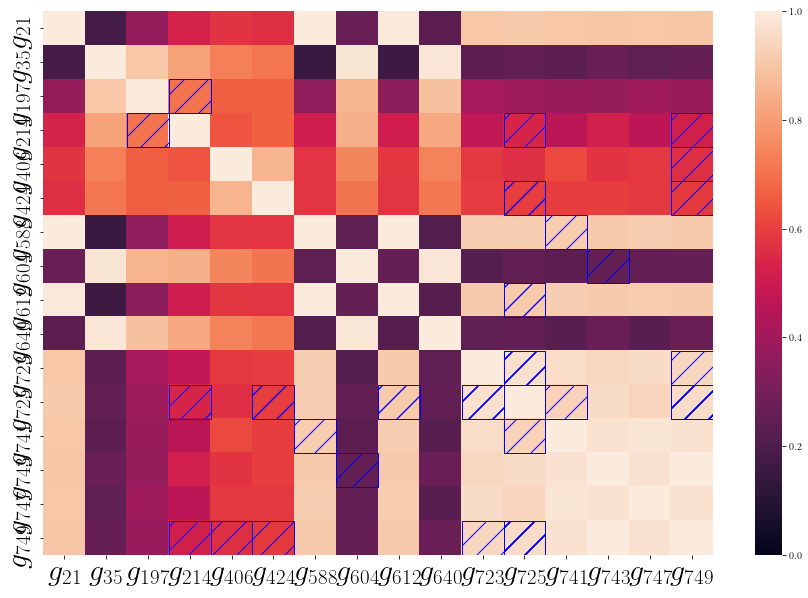

In [15]:
# selected_lasso = results['selected_lasso']
# names_lasso = get_names(selected_lasso)
# colors_lasso = get_cmap(selected_lasso)
# selected_lasso_gt = np.unique(np.concatenate((gt_ind, selected_lasso))) #add 234
# #detected_values = get_detected_values2d(selected_lasso_gt, results['supports_lasso'][0],nreps)
# colors_lasso_plusgt = np.vstack([colors_gt, colors_lasso])
# names_lasso_plusgt = np.concatenate((names_gt, names_lasso))
# cuz_l = np.abs(get_cosines(results['replicates_small'][0].dg_M[:,:,selected_lasso_gt]))
# cuz_l0 = np.mean(cuz_l, axis = 0)
# fig, axarr = plt.subplots(figsize=(15, 10))
# sns.heatmap(cuz_l0, yticklabels = names_lasso_plusgt, xticklabels = names_lasso_plusgt, ax = axarr, vmin = 0., vmax = 1.)
# axarr.set_xticklabels(axarr.get_xmajorticklabels(), fontsize = 30)
# axarr.set_yticklabels(axarr.get_ymajorticklabels(), fontsize = 30)
# d = 2
# nreps = 25
# if d == 2:
#     for r in range(nreps):
        
#         pos1 = np.where(selected_lasso_gt == results['supports_lasso'][1][r,1])[0]
#         pos2 =  np.where(selected_lasso_gt == results['supports_lasso'][1][r,0])[0]
#         axarr.add_patch(Rectangle((pos1, pos2), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))
#         axarr.add_patch(Rectangle((pos2, pos1), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))


In [9]:
# selected_ts = results['selected_ts']
# colors_ts = get_cmap(selected_ts)
# names_ts = get_names(selected_ts)
# colors_gt=  [[0,0,1,1], [1,0.64,0,1]]
# names_ts = get_names(selected_ts)
# colors_ts = get_cmap(selected_ts)
# selected_ts_gt = np.unique(np.concatenate((gt_ind, selected_ts))) #add 234
# colors_ts_plusgt = np.vstack([colors_gt, colors_ts])
# names_ts_plusgt = np.concatenate((names_gt, names_ts))


In [10]:
# cuz_l = np.abs(get_cosines(results['replicates_small'][0].dg_M[:,:,selected_ts_gt]))
# cuz_l0 = np.mean(cuz_l, axis = 0)


In [15]:
# def plot_cos_boxes(sup_sel, names, col, sel, d , nreps, axarr):


#     sns.heatmap(col, yticklabels = names, xticklabels = names, ax = axarr, vmin = 0., vmax = 1.)
#     axarr.set_xticklabels(axarr.get_xmajorticklabels(), fontsize = 30)
#     axarr.set_yticklabels(axarr.get_ymajorticklabels(), fontsize = 30)

#     if d == 2:
#         for r in range(nreps):
#             pos1 = np.where(sel == sup_sel[r,1])[0]
#             pos2 =  np.where(sel == sup_sel[r,0])[0]
#             axarr.add_patch(Rectangle((pos1, pos2), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))
#             axarr.add_patch(Rectangle((pos2, pos1), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))


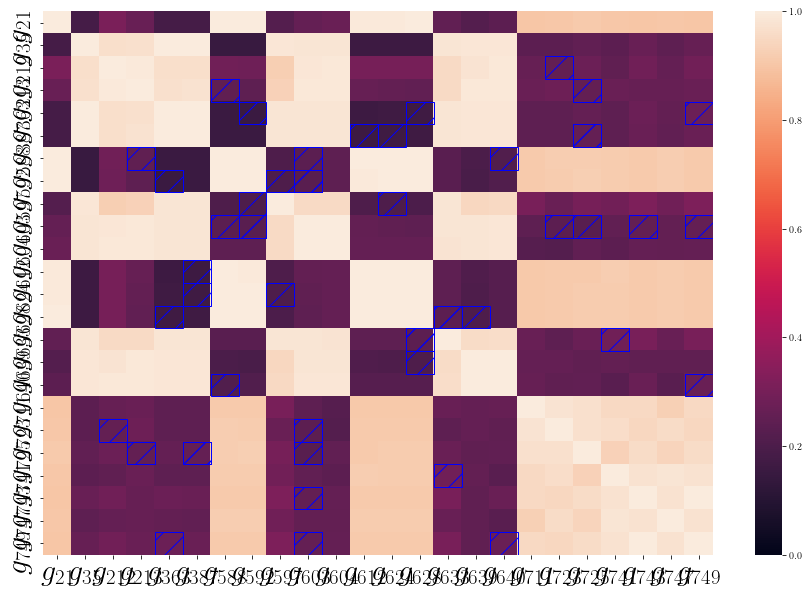

In [17]:
# plot_cos_boxes(results['supports_ts'][1], names_ts_plusgt, cuz_l0, selected_ts_gt, d , nreps)

In [ ]:
# fig, axarr = plt.subplots(figsize=(15, 10))
# sns.heatmap(cuz_l0, yticklabels = names_ts_plusgt, xticklabels = names_ts_plusgt, ax = axarr, vmin = 0., vmax = 1.)
# axarr.set_xticklabels(axarr.get_xmajorticklabels(), fontsize = 30)
# axarr.set_yticklabels(axarr.get_ymajorticklabels(), fontsize = 30)
# d = 2
# nreps = 25
# if d == 2:
#     for r in range(nreps):
#         pos1 = np.where(selected_ts_gt == results['supports_ts'][1][r,1])[0]
#         pos2 =  np.where(selected_ts_gt == results['supports_ts'][1][r,0])[0]
#         axarr.add_patch(Rectangle((pos1, pos2), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))
#         axarr.add_patch(Rectangle((pos2, pos1), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))
